# Melnikov Evgeny 18PMI


In [6]:
!pip install pymystem3 selenium html2text requests beautifulsoup4 atlas json2xml

In [3]:
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options

from time import sleep
# import tqdm
from tqdm.notebook import tqdm
import json
import time


import requests
from bs4 import BeautifulSoup
from html2text import html2text

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [57]:
json_filename = "data.json"
categories = ["transport", "auto", "health", "incidents"]

In [4]:
chrome_driver_path = "chromedriver.exe"

## Lab1


In [3]:
# The function extracts article data from www.nn.ru and writes it in JSON format to out_filename
# The extracted data is: 
# - article link (article_id) 
# - article title 
# - article category
# - article tags 
# - article text
# The category and number of articles is specified by categories and article_num respectively

def parse_nnru(article_num, categories, out_filename, progress_bar=True):
    # progress bar setup   
    if progress_bar:
        category_bar = tqdm(range(len(categories)), desc = 'Category progress')
        article_bar = tqdm(range(article_num), desc = 'Article progress', leave = False)

    # create output json file
    with open(out_filename,'w', encoding="utf-8") as file:
        pass
    
    # set Chrome options and preferences
    prefs = {"profile.managed_default_content_settings.images": 2,
             "profile.default_content_settings.cookies": 2}
    chrome_options = Options()
    chrome_options.add_extension('adblock.crx')
    chrome_options.add_experimental_option("prefs",prefs) 
    chrome_options.add_argument('--disable-application-cache')
    
    driver = Chrome(executable_path=chrome_driver_path, chrome_options=chrome_options)
    driver.implicitly_wait(10)
    driver.close()
    print("Current session is {}".format(driver.session_id))
    driver.switch_to.window(driver.window_handles[0])
    
    driver.get('chrome-extension://gighmmpiobklfepjocnamgkkbiglidom/options.html')
    driver.find_element_by_id('acceptable_ads').click() # adblock customization
       
    for category in categories:
        # progress bar
        if progress_bar:
            category_bar.update(1)
            article_bar.reset()
            
        article_count = 0
        page = 1       
        while(1):
            while_break_flag = False # used to break while(1) from the nested for-loop
            
            driver.get(f'https://www.nn.ru/text/?rubric={category}&page={page}')           
            
            #for element in driver.find_elements_by_xpath("//article"):
            for element in driver.find_elements_by_xpath("//*[@class='_3-SyJ']"): # tags with this specific class contain article previews
                json_dict = {}            
                # article's link  
                json_dict['article_id'] = element.find_element_by_tag_name('a').get_attribute('href')
                
                soup = BeautifulSoup(requests.get(json_dict['article_id']).text, "lxml")            

                # article's title 
                json_dict['title'] = ''
                title = soup.find('h1', attrs={'itemprop': 'headline'}, recursive=True)
                if title is None:
                    continue
                else:
                    json_dict['title'] = title.getText()
                
                # article's category  
                json_dict['category'] = category

                # article's tags        
                json_dict['tags'] = []
                div_tags = soup.find('div', attrs={'class': '_2TvYC'}, recursive=True) # <div class="_2TvYC"> contains tags of an article
                if div_tags is not None: # some articles may not have tags at all            
                    div_tags_children = div_tags.findChildren('span')
                    for child in div_tags_children: # iterate over <span> children
                        json_dict['tags'].append(child.getText()) # transform type bs4.element.Tag into str and append to a list
                else:
                    #continue
                    pass
                
                # article's text 
                json_dict['text'] = ''
                div_article = soup.find('div', attrs={'itemprop': 'articleBody'}) # find a <div>, which contains the article itself
                if div_article is None: # if the div with an article hasn't been found
                    continue                
                for figure_tag in div_article.find_all('figure', attrs={'itemscope': 'itemscope'}):
                    figure_tag.extract() # remove all <figure itemscope='itemscoppe'> tags, which contain images and image-related text
                text = ''
                for paragraph in div_article.find_all(['p', 'li'], attrs={'class': ''}):
                    json_dict['text'] += paragraph.getText(separator=" ") + ' ' # s
                    # NOTE: there may be double spaces in some places
                
                # write data to output json file                
                with open(out_filename,'a', encoding="utf-8") as file:
                    file.write(json.dumps(json_dict, ensure_ascii=False) + '\n')
                
                # progress bar
                if progress_bar:
                    article_bar.update(1)
    
                # check whether the number of articles is sufficient
                article_count+=1
                if article_count >= article_num:
                    while_break_flag = True
                    break
                
            if while_break_flag is True: # break the while-loop from the inner for-loop if the amount of fetched articles is sufficient
                break
            else:
                page+= 1 # otherwise, fetch articles from the next page    
        
    driver.quit()


In [4]:
parse_nnru(1000, categories, json_filename)

Category progress:   0%|          | 0/4 [00:00<?, ?it/s]

Article progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Current session is 70a471e794ddfd8d811daa0b572a4862


In [ ]:
data = pd.read_json(json_filename, lines=True)
data

## Lab 2


In [1]:
!pip install nltk sklearn wordcloud pymorphy2 stop_words

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=327cc1b124262a06ac7aa54fe02c6545a95aa559034031a977bfac76b54fc274
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=5240080757c8c051d2538ae6c08620776000b9ff320485608a9c190f43733357
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32916 sha256=556469d6f6b946a243307971d2f855758c6d4671544214e70626d0a98cc19269
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\eb\03\0d\3bd31c983789aeb0b4d5e2ca48590288d9db1586cf5f225062
Successfully built docopt sklearn stop-words


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from scipy.sparse import *
import stop_words
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
raw_data = pd.read_json(json_filename, lines=True)

### 1. Text preprocessing

In [10]:
# the function preprocesses input text, i. e. removes digits, punctuation, special characters, etc.
# and converts words to normal form.
# As for return value, the preprocessed text is either left as is, tokenized by words or tokenized by sentences.

def preprocess_text(input_text, tokenize_by='sentence'):
    
    if tokenize_by != 'word' and tokenize_by != 'sentence' and tokenize_by != 'text':
        raise Exception("tokenize_by can only be 'word', 'sentence' or 'text'")
    
    # copy a string
    output_text = input_text[:]
    
    # convert letters to lowercase
    output_text = output_text.lower() 
    
    # remove multiple spaces 
    output_text = re.sub(r' +', 
                         ' ', 
                         output_text)
    
    # remove links
    output_text = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-—_=#])*', 
                                          '', 
                                          output_text)
    
    # remove email addresses
    output_text = re.sub(r'^([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})$', 
                                          '', 
                                          output_text) 

    # remove phone numbers (not working)
    output_text = re.sub(r'^(?:\s*-*\s*\d){8}$', 
                                          '', 
                                          output_text)

    # tokenize sentences
    output_text = sent_tokenize(output_text) 
    
    # remove special characters
    special_chars = ''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])
    regex_special_chars = re.compile(f'[{re.escape(special_chars)}]')
    output_text = [regex_special_chars.sub('', sent) for sent in output_text]
    
    # remove all punctuation
    regex_punct = re.compile(f'[{re.escape(string.punctuation)}]') # punctuation to exclude 
    output_text = [regex_punct.sub('', sent) for sent in output_text]
    
    # remove all digits
    regex_dig = re.compile(f'[{re.escape(string.digits)}]')
    output_text = [regex_dig.sub('', sent) for sent in output_text]
    
    # tokenize words 
    output_text = [word_tokenize(sent) for sent in output_text]
    
    # exclude stop-words
    stop_words_list = stopwords.words('russian') # nltk package
    # stop_words_list = stop_words.get_stop_words('russian') # stop_words package   
    output_text = [[word for word in sent if word not in stop_words_list] for sent in output_text] # kinda unreadable?
    
    # lemmatize (convert words to the base/normal form)
    morph = pymorphy2.MorphAnalyzer()
    output_text = [[morph.parse(word)[0].normal_form for word in sent if word not in stop_words_list] for sent in output_text] 
    
    if tokenize_by == 'word':  
        return output_text
    elif tokenize_by == 'sentence':
        return [' '.join(sent) for sent in output_text]
    elif tokenize_by == 'text':
        return ' '.join([' '.join(sent) for sent in output_text])


### 2. Text vectorization (with preprocessing)

In [11]:
# The function goes through the data from JSON, preprocesses the text of each entry using preprocess_text() function
# and vectorizes the texts using TfidVectorizer()

def vectorize_text_all(raw_input_data):
    raw_input_data_len = raw_input_data.shape[0] # number of rows
    # raw_input_data_len = 100
    texts = []
    y = [] 

    bar = tqdm(range(raw_input_data_len), desc = 'Article progress')
    for i in range(raw_input_data_len):
        texts.append(preprocess_text(raw_input_data['text'][i], tokenize_by='text'))
        y.append(raw_input_data['category'][i])
        bar.update(1)   
    bar.close()

    vectorizer = TfidfVectorizer()    
    X = vectorizer.fit_transform(texts)
    X = X.toarray()
    X = pd.DataFrame(data=X, columns=vectorizer.get_feature_names())
    
    return X, y

In [12]:
X, y = vectorize_text_all(raw_data)

Article progress:   0%|          | 0/4000 [00:00<?, ?it/s]

### 3. Experiments with classic ML algorithms

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

The train and test sets are split 80/20. 

The classes are balanced in both test and train samples:

<AxesSubplot:>

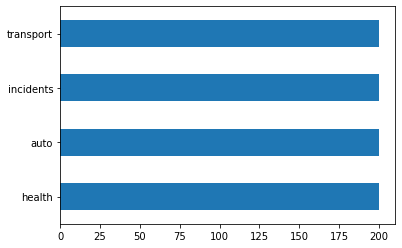

In [30]:
pd.Series(y_test).value_counts().plot(kind='barh')

<AxesSubplot:>

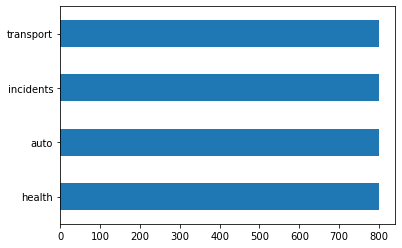

In [31]:
pd.Series(y_train).value_counts().plot(kind='barh')

GridSearchCV will be used for hyperparameter tuning. The best hyperparameters are chosen by the highest f-1 value

#### 3.1 KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': [2, 4, 8, 16],
    'weights': ['distance', 'uniform'],
    'metric': ['minkowski', 'euclidean']
}

gs_knn = GridSearchCV(
    KNeighborsClassifier(),
    params,
    scoring='f1',
    verbose=3,
    cv=2,
    n_jobs=1,
)

# knn = KNeighborsClassifier(n_neighbors=2)
gs_knn.fit(X_train, y_train)
gs_knn.best_params_

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END metric=minkowski, n_neighbors=2, weights=distance; total time=   4.8s
[CV 2/2] END metric=minkowski, n_neighbors=2, weights=distance; total time=   4.8s
[CV 1/2] END metric=minkowski, n_neighbors=2, weights=uniform; total time=   4.2s
[CV 2/2] END metric=minkowski, n_neighbors=2, weights=uniform; total time=   4.0s
[CV 1/2] END metric=minkowski, n_neighbors=4, weights=distance; total time=   4.3s
[CV 2/2] END metric=minkowski, n_neighbors=4, weights=distance; total time=   4.0s
[CV 1/2] END metric=minkowski, n_neighbors=4, weights=uniform; total time=   4.0s
[CV 2/2] END metric=minkowski, n_neighbors=4, weights=uniform; total time=   4.8s
[CV 1/2] END metric=minkowski, n_neighbors=8, weights=distance; total time=   4.4s
[CV 2/2] END metric=minkowski, n_neighbors=8, weights=distance; total time=   5.1s
[CV 1/2] END metric=minkowski, n_neighbors=8, weights=uniform; total time=   5.0s
[CV 2/2] END metric=minkowski, 

{'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}

In [40]:
y_pred = gs_knn.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.97      0.31      0.47       634
      health       0.27      0.98      0.42        55
   incidents       0.18      0.90      0.30        40
   transport       0.32      0.90      0.47        71

    accuracy                           0.44       800
   macro avg       0.44      0.77      0.42       800
weighted avg       0.83      0.44      0.46       800



Seems like KNN prefers the "auto" class for some reason, therefore, the f1-score is low

#### 3.2 Decision tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [4, 8, 16, 20, 30],
    'min_samples_leaf': [1, 2, 4, 8],
    'min_samples_split': [2, 5, 10]
}

gs_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    params,
    scoring='f1',
    verbose=3,
    cv=2,
    n_jobs=1
)

gs_tree.fit(X_train, y_train)
gs_tree.best_params_

Fitting 2 folds for each of 60 candidates, totalling 120 fits
[CV 1/2] END max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   5.3s
[CV 2/2] END max_depth=4, min_samples_leaf=1, min_samples_split=2; total time=   5.4s
[CV 1/2] END max_depth=4, min_samples_leaf=1, min_samples_split=5; total time=   5.5s
[CV 2/2] END max_depth=4, min_samples_leaf=1, min_samples_split=5; total time=   5.5s
[CV 1/2] END max_depth=4, min_samples_leaf=1, min_samples_split=10; total time=   5.8s
[CV 2/2] END max_depth=4, min_samples_leaf=1, min_samples_split=10; total time=   5.8s
[CV 1/2] END max_depth=4, min_samples_leaf=2, min_samples_split=2; total time=   5.8s
[CV 2/2] END max_depth=4, min_samples_leaf=2, min_samples_split=2; total time=   5.9s
[CV 1/2] END max_depth=4, min_samples_leaf=2, min_samples_split=5; total time=   5.7s
[CV 2/2] END max_depth=4, min_samples_leaf=2, min_samples_split=5; total time=   9.9s
[CV 1/2] END max_depth=4, min_samples_leaf=2, min_samples_split=10; total ti

[CV 1/2] END max_depth=20, min_samples_leaf=8, min_samples_split=10; total time=   9.0s
[CV 2/2] END max_depth=20, min_samples_leaf=8, min_samples_split=10; total time=   8.2s
[CV 1/2] END max_depth=30, min_samples_leaf=1, min_samples_split=2; total time=  11.1s
[CV 2/2] END max_depth=30, min_samples_leaf=1, min_samples_split=2; total time=   9.1s
[CV 1/2] END max_depth=30, min_samples_leaf=1, min_samples_split=5; total time=   8.6s
[CV 2/2] END max_depth=30, min_samples_leaf=1, min_samples_split=5; total time=   8.4s
[CV 1/2] END max_depth=30, min_samples_leaf=1, min_samples_split=10; total time=   9.2s
[CV 2/2] END max_depth=30, min_samples_leaf=1, min_samples_split=10; total time=  12.1s
[CV 1/2] END max_depth=30, min_samples_leaf=2, min_samples_split=2; total time=  15.8s
[CV 2/2] END max_depth=30, min_samples_leaf=2, min_samples_split=2; total time=   9.7s
[CV 1/2] END max_depth=30, min_samples_leaf=2, min_samples_split=5; total time=   9.3s
[CV 2/2] END max_depth=30, min_samples_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [38]:
y_pred = gs_tree.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.57      0.84      0.68       135
      health       0.86      0.89      0.88       195
   incidents       0.48      0.75      0.59       128
   transport       0.80      0.46      0.59       342

    accuracy                           0.68       800
   macro avg       0.68      0.74      0.68       800
weighted avg       0.72      0.68      0.67       800



Overall, the dicision tree has achieved better scores than KNN

#### 3.3 Random forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': [2, 4, 8, 16, 32],
    'max_depth': [4],
    'min_samples_leaf': [1],
    'min_samples_split': [2]
}

gs_rforest = GridSearchCV(
    RandomForestClassifier(random_state=42),
    params,
    scoring='f1',
    verbose=3,
    cv=2,
    n_jobs=1
)

gs_rforest.fit(X_train, y_train)
gs_rforest.best_params_

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2] END max_depth=4, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV 2/2] END max_depth=4, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV 1/2] END max_depth=4, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV 2/2] END max_depth=4, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV 1/2] END max_depth=4, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV 2/2] END max_depth=4, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV 1/2] END max_depth=4, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV 2/2] END max_depth=4, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; 

{'max_depth': 4,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [47]:
y_pred = gs_rforest.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.39      0.74      0.51       105
      health       0.64      0.71      0.67       180
   incidents       0.86      0.37      0.51       468
   transport       0.12      0.49      0.19        47

    accuracy                           0.50       800
   macro avg       0.50      0.58      0.47       800
weighted avg       0.71      0.50      0.53       800



Weirdly, Random Forest has got worse results than decision tree

#### 3.4 SVM

In [103]:
from sklearn.svm import SVC

params = {
    'C': [0.1, 1, 10], 
    'gamma': [1, 0.1, 0.01], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}

gs_svm = GridSearchCV(
    SVC(random_state=42),
    params,
    scoring='f1',
    verbose=3,
    cv=2,
    n_jobs=1
)


gs_svm.fit(X_train, y_train)
gs_svm.best_params_

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV 1/2] END .....................C=0.1, gamma=1, kernel=rbf; total time= 5.0min
[CV 2/2] END .....................C=0.1, gamma=1, kernel=rbf; total time= 4.0min
[CV 1/2] END ....................C=0.1, gamma=1, kernel=poly; total time= 3.2min
[CV 2/2] END ....................C=0.1, gamma=1, kernel=poly; total time= 3.2min
[CV 1/2] END .................C=0.1, gamma=1, kernel=sigmoid; total time= 2.9min
[CV 2/2] END .................C=0.1, gamma=1, kernel=sigmoid; total time= 2.9min
[CV 1/2] END ...................C=0.1, gamma=0.1, kernel=rbf; total time= 4.2min
[CV 2/2] END ...................C=0.1, gamma=0.1, kernel=rbf; total time= 4.3min
[CV 1/2] END ..................C=0.1, gamma=0.1, kernel=poly; total time= 3.5min
[CV 2/2] END ..................C=0.1, gamma=0.1, kernel=poly; total time= 3.5min
[CV 1/2] END ...............C=0.1, gamma=0.1, kernel=sigmoid; total time= 3.5min
[CV 2/2] END ...............C=0.1, gamma=0.1, ke

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

In [104]:
y_pred = gs_svm.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.77      0.81      0.79       189
      health       0.85      0.99      0.91       172
   incidents       0.94      0.85      0.89       219
   transport       0.83      0.76      0.80       220

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800



#### 3.5 Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

params = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs']
}

gs_logreg = GridSearchCV(
    LogisticRegression(random_state=42),
    params,
    scoring='f1',
    verbose=3,
    cv=2,
    n_jobs=1
)

gs_logreg.fit(X_train, y_train)
gs_logreg.best_params_

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV 1/2] END ..........C=0.1, penalty=none, solver=newton-cg; total time=  41.7s
[CV 2/2] END ..........C=0.1, penalty=none, solver=newton-cg; total time=  47.6s
[CV 1/2] END ..............C=0.1, penalty=none, solver=lbfgs; total time=  14.9s
[CV 2/2] END ..............C=0.1, penalty=none, solver=lbfgs; total time=  20.1s
[CV 1/2] END ............C=0.1, penalty=l1, solver=newton-cg; total time=   0.5s
[CV 2/2] END ............C=0.1, penalty=l1, solver=newton-cg; total time=   0.4s
[CV 1/2] END ................C=0.1, penalty=l1, solver=lbfgs; total time=   0.5s
[CV 2/2] END ................C=0.1, penalty=l1, solver=lbfgs; total time=   0.4s
[CV 1/2] END ............C=0.1, penalty=l2, solver=newton-cg; total time=  13.9s
[CV 2/2] END ............C=0.1, penalty=l2, solver=newton-cg; total time=  10.5s
[CV 1/2] END ................C=0.1, penalty=l2, solver=lbfgs; total time=   9.5s
[CV 2/2] END ................C=0.1, penalty=l2, 

{'C': 0.1, 'penalty': 'none', 'solver': 'newton-cg'}

In [43]:
y_pred = gs_logreg.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.86      0.90      0.88       191
      health       0.95      0.98      0.97       194
   incidents       0.93      0.88      0.90       212
   transport       0.85      0.84      0.84       203

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



#### 3.6 Ridge Regression

In [44]:
from sklearn.linear_model import RidgeClassifier

params = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

gs_ridgereg = GridSearchCV(
    RidgeClassifier(random_state=42),
    params,
    scoring='f1',
    verbose=3,
    cv=2,
    n_jobs=1
)

gs_ridgereg.fit(X_train, y_train)
gs_ridgereg.best_params_

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2] END ......................................alpha=0.1; total time=   3.6s
[CV 2/2] END ......................................alpha=0.1; total time=   3.6s
[CV 1/2] END ......................................alpha=0.2; total time=   3.3s
[CV 2/2] END ......................................alpha=0.2; total time=   3.4s
[CV 1/2] END ......................................alpha=0.3; total time=   3.4s
[CV 2/2] END ......................................alpha=0.3; total time=   3.4s
[CV 1/2] END ......................................alpha=0.4; total time=   3.4s
[CV 2/2] END ......................................alpha=0.4; total time=   3.4s
[CV 1/2] END ......................................alpha=0.5; total time=   3.4s
[CV 2/2] END ......................................alpha=0.5; total time=   3.3s
[CV 1/2] END ......................................alpha=0.6; total time=   3.4s
[CV 2/2] END ...................................

{'alpha': 0.1}

In [45]:
y_pred = gs_ridgereg.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

        auto       0.87      0.89      0.88       196
      health       0.96      0.97      0.97       197
   incidents       0.91      0.89      0.90       204
   transport       0.85      0.84      0.85       203

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



### 4. Comparison

Let's print out all the classification reports at once

In [105]:
y_pred_knn = gs_knn.predict(X_test)
print("KNN:")
print(classification_report(y_pred_knn, y_test))

y_pred_tree = gs_tree.predict(X_test)
print("Decision Tree:")
print(classification_report(y_pred_tree, y_test))

y_pred_svm = gs_svm.predict(X_test)
print("SVM:")
print(classification_report(y_pred_svm, y_test))

y_pred_rforest = gs_rforest.predict(X_test)
print("Random Forest:")
print(classification_report(y_pred_rforest, y_test))

y_pred_logreg = gs_logreg.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_pred_logreg, y_test))

y_pred_ridgereg = gs_ridgereg.predict(X_test)
print("Ridge Regression:")
print(classification_report(y_pred_ridgereg, y_test))

KNN:
              precision    recall  f1-score   support

        auto       0.97      0.31      0.47       634
      health       0.27      0.98      0.42        55
   incidents       0.18      0.90      0.30        40
   transport       0.32      0.90      0.47        71

    accuracy                           0.44       800
   macro avg       0.44      0.77      0.42       800
weighted avg       0.83      0.44      0.46       800

Decision Tree:
              precision    recall  f1-score   support

        auto       0.57      0.84      0.68       135
      health       0.86      0.89      0.88       195
   incidents       0.48      0.75      0.59       128
   transport       0.80      0.46      0.59       342

    accuracy                           0.68       800
   macro avg       0.68      0.74      0.68       800
weighted avg       0.72      0.68      0.67       800

SVM:
              precision    recall  f1-score   support

        auto       0.77      0.81      0.79       

The best scores have been achieved by Logistic Regression and Ridge Regression. The f-1 score values are the same and precision, recall and accuracy score differ no more than by 0.01.

Let's compare ROC AUC values:

Text(0.5, 1.0, 'ROC AUC values')

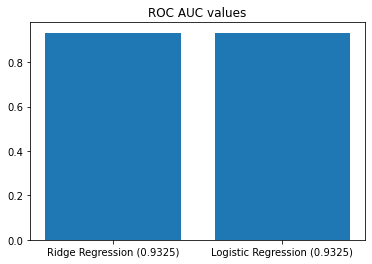

In [102]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(np.array(categories).reshape(-1, 1))
encoder.transform(np.array(y_test).reshape(-1, 1))

roc_auc_ridgereg = roc_auc_score(
    encoder.transform(np.array(y_test).reshape(-1, 1)).toarray(),
    encoder.transform(np.array(y_pred_ridgereg).reshape(-1, 1)).toarray(), 
    multi_class='ovr'
)

roc_auc_logreg = roc_auc_score(
    encoder.transform(np.array(y_test).reshape(-1, 1)).toarray(),
    encoder.transform(np.array(y_pred_logreg).reshape(-1, 1)).toarray(), 
    multi_class='ovr'
)

fig, ax = plt.subplots()
ax.bar([f'Ridge Regression ({round(roc_auc_ridgereg, 5)})', f'Logistic Regression ({roc_auc_logreg})'], [roc_auc_ridgereg, roc_auc_logreg])
ax.set_title('ROC AUC values')

ROC AUC values are also the same. 

Thus, the best ML models are Logistic and Linear Regression with f-1 scores of 0.9